# Mask Generation
使用 Mindspore 和 MindSpore NLP 实现基于 `Segformer` 的掩码生成。


SegFormer 是一种用于**语义分割**任务的深度学习模型，由 NVIDIA 提出。它结合了Transformer和卷积神经网络(CNN)的优点，实现了高效且准确的语义分割。SegFormer的主要创新点在于它使用了Transformer架构进行图像特征提取，而不是传统的卷积神经网络（CNN）架构。SegFormer 有多个不同复杂度的版本，常见的包括 SegFormer-B0、SegFormer-B1、SegFormer-B2、SegFormer-B3、SegFormer-B4 等。这些版本主要在参数量、计算开销（FLOPs）、模型大小上有所区别，以满足不同任务和硬件条件的需求。

##### SegFormer的关键特点：
1. Transformer架构：
   - SegFormer 利用 Transformer 架构中的自注意力机制，能够更好地捕捉长距离依赖和全局上下文信息。这在语义分割任务中非常重要，因为它可以帮助模型更准确地理解图像中的不同对象和它们之间的关系。

2. 没有位置编码（Position Embedding：
   - 与许多基于 Transformer 的模型不同，SegFormer 不依赖于显式的位置编码。它通过逐步的上下采样（downsampling）和上采样（upsampling）操作，直接从图像中提取多尺度特征，而不是依赖于输入图像的位置信息。

3. 多尺度特征融合：
   - SegFormer 在不同分辨率上提取多尺度特征，并通过融合不同尺度的信息来提高分割精度。这使得它在处理复杂场景中的小物体时也能表现出色。

In [1]:
from mindnlp.transformers import SegformerImageProcessor, SegformerForSemanticSegmentation      
import mindspore      



/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/Mindspore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Building prefix dict from the default dictionary .

In [ ]:
# 加载预训练的 SegFormer 模型
processor = SegformerImageProcessor(do_resize=False)         
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

[MS_ALLOC_CONF]Runtime config:  enable_vmm:True  vmm_align_size:2MB


#### 预处理图片
这里，我们从ADE20k数据集（实际上称为MIT场景解析基准）中加载一张图片。我们还加载了其对应的真实分割标注图，可以使用图像处理器为模型准备图像，它将调整图像大小 + 标准化通道。

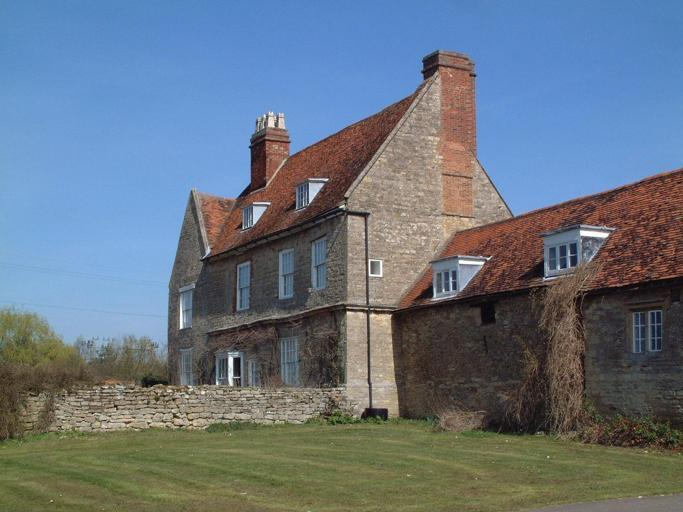

In [3]:
from huggingface_hub import hf_hub_download
from PIL import Image

# load image + ground truth map
repo_id = "hf-internal-testing/fixtures_ade20k"
image_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000001.jpg", repo_type="dataset")
image = Image.open(image_path)
segmentation_map_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000001.png", repo_type="dataset")
segmentation_map = Image.open(segmentation_map_path)
image

In [4]:
# 处理输入图像，返回MindSpore Tensor
inputs = processor(images=image, return_tensors="ms")  # 使用“ms”来生成MindSpore的tensor
pixel_values = inputs['pixel_values']  # 从返回的字典中提取 pixel_values
print(pixel_values.shape)

(1, 3, 512, 683)


##### 向前传播

In [5]:
import mindspore.ops as ops
import mindnlp.core.ops

# Monkey patch: 动态为mindnlp.core.ops插入interpolate操作
mindnlp.core.ops.interpolate = ops.interpolate

In [6]:
from mindspore import ops

# 前向传播进行推理，计算logits
outputs = model(pixel_values)     #这里调用了

# 提取logits
logits = outputs['logits']  # 在MindSpore中，可能需要从字典中提取

# 打印 logits 的形状
logits_shape = logits.shape
print(logits_shape)  


(1, 150, 128, 171)


#### 进行可视化


In [7]:
predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.numpy()
print(predicted_segmentation_map)

[[ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 ...
 [ 9  9  9 ... 52 52 52]
 [ 9  9  9 ... 52 52 52]
 [ 9  9  9 ... 52 52 52]]


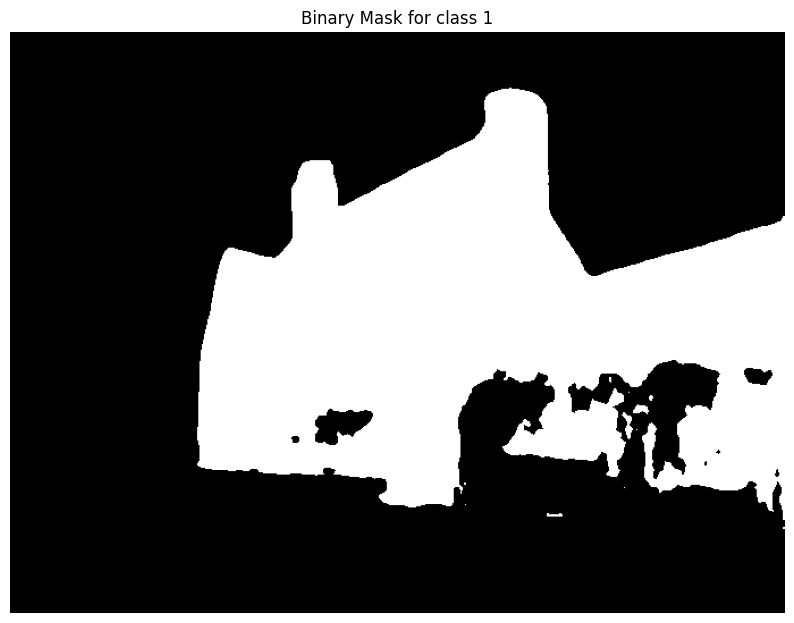

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# 
# 指定类别 ID
TARGET_CLASS_ID = 1

# 生成二值化 mask：目标=255，其他=0
binary_mask = (predicted_segmentation_map ==
               TARGET_CLASS_ID).astype(np.uint8) * 255

# 可视化
plt.figure(figsize=(10, 8))
plt.imshow(binary_mask, cmap="gray")
plt.title(f"Binary Mask for class {TARGET_CLASS_ID}")
plt.axis("off")
plt.show()

# 如果要保存
# from PIL import Image
# Image.fromarray(binary_mask).save(f"class_{TARGET_CLASS_ID}_mask.png")